In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations
from collections import Counter
import math
from functools import partial
from tqdm import tqdm
from p_tqdm import p_map, p_umap, p_imap, p_uimap
from multiprocessing.pool import ThreadPool as Pool
from multiprocessing import Process
import time

plt.style.use('ggplot')

In [2]:
# This function implements the Knn classifier by computing the euclidean distance between data points
def knn(k, predicted_x, predicted_y, pool):
    
    predicted_dp = np.array([predicted_x, predicted_y, 0.0])
    distances = predicted_dp - pool
    distances = np.power(distances, 2)
    distances = distances[:,0:2] 
    distances = np.sum(distances, axis=1)
    distances = np.sqrt(distances)
    
    vote_pool_indices = np.argsort(distances)[:k]
    vote_pool_classes = [pool[i][2] for i in vote_pool_indices]
    vote_result = Counter(vote_pool_classes).most_common()
    
    return vote_result[0][0]


In [3]:
# # Array broadcasting
# rowMatrix = np.array([1, 29, 30])
# columnMatrix = np.array([[1, 2, 5], [2, 7, 4], [3, 5, 2]])

# print('#########')
# print(columnMatrix[:, 0:2])

# print('#########')
# r = rowMatrix -  columnMatrix
# print(r)


# print('#########')
# r1 = np.sum(r, axis=1)
# print(r1)



# Read dataset

In [4]:
df = pd.read_csv('hw5data.txt', sep= ' ', names= ['x','y', 'class'])
df

,x,y,class
0,0.776233,0.052780,1
1,0.992234,0.087356,1
2,0.263741,0.131315,1
3,0.079478,0.109225,1
4,0.688997,0.983182,1
...,...,...,...
802,0.932700,0.875138,0
803,0.541090,0.555108,0
804,0.988755,0.194709,0
805,0.263414,0.974600,0


<Axes: ylabel='Frequency'>

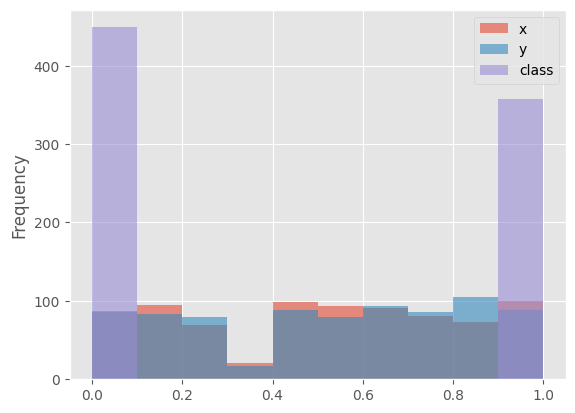

In [5]:
df.plot(kind= 'hist', alpha=0.6)

<Axes: xlabel='x', ylabel='y'>

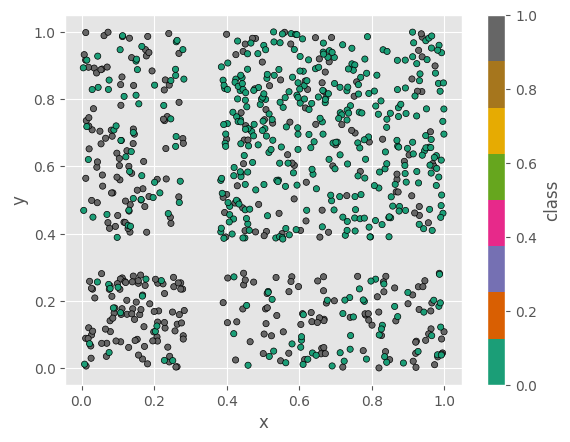

In [6]:
df.plot(x= 'x', y = 'y', c='class', kind= 'scatter', colormap= 'Dark2', edgecolor='k')

In [7]:
# Create a dense 2D grid of data points 
mesh_X, mesh_Y = np.mgrid[0:1:5j,0:1:5j]

n = 20
K = 1

# Target classifier, g: It has a array P which is the classifier computed using all points in P (hw5data.txt). 
P = df.to_numpy() 
print(f'Dataset of target classifier: {P.shape}')

# Teaching/ student classifier, f: It has a array D which picks elements from P (hw5data.txt) D is a 
# subset or proper set of P, which holds the data points we want to include in teaching.
D = np.array([])
print(f'Dataset of teaching classifier: {D.shape}')

Dataset of target classifier: (807, 3)
Dataset of teaching classifier: (0,)


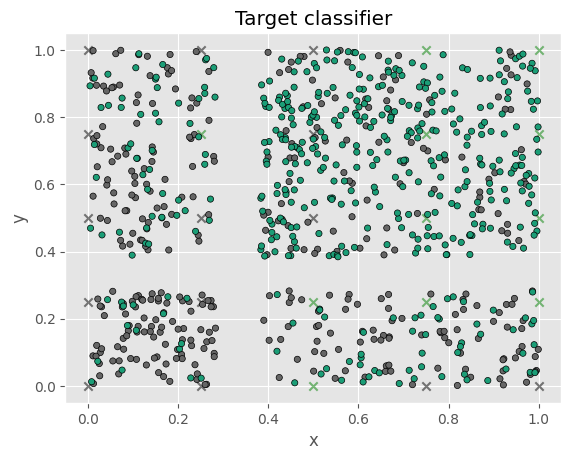

In [8]:
colors = {0: 'green', 1:'black'}
# View decision boundary of target classifier using all data points from the orignal pool
for X, Y in zip(mesh_X, mesh_Y):
    for x, y in zip(X, Y):
        result = knn(K, x,y, P)
        plt.scatter(x,y, c= colors[result],alpha= 0.5, marker='x')
        
temp_P = P.T
plt.scatter(temp_P[0], temp_P[1], c=temp_P[2], edgecolor='k', cmap='Dark2', s=20)
plt.title('Target classifier')
plt.xlabel('x')
plt.ylabel('y')
        
plt.show()

In [9]:
# We than use the dense grid to map it onto both the target classifier and teaching classifier. This generates
# feature vectors (x_{1}, x_{2}, y) with the same dimensions.

# Both feature vectors are fed into the disagreement function, which compares each dense grid points correspondingly
# by comparing their corresponding
# f(x') - computed from teaching classifier, and y' - computed from target classifiers which is defined in the disagreement function.
# Return the result of the unified cost function.

# Use that cost function result to do enumeration and greedy respectively. 

# Map the dense 2D grid to the target classifier, since we will be using it for all comparisons.


In [10]:
%%time
# We precompute and store target classifier to avoid recomputation
target_class_mesh = []
for i in range(len(mesh_X)):
    res = []
    for j in range(len(mesh_X[0])):
        res.append(knn(K, mesh_X[i][j], mesh_Y[i][j], P))
        
    target_class_mesh.append(res)
    
target_class_mesh = np.array(target_class_mesh)

print(f'target mesh:\n {target_class_mesh} ') # The top left corner of the mesh is at origin, hence explaining the 90 degree anti-clockwise turn in the plot.

target mesh:
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]] 
CPU times: user 6.35 ms, sys: 982 µs, total: 7.33 ms
Wall time: 2.84 ms


In [11]:
%%time
# Enumeration

# This function
def find_combination(n, pool):
    datasets = combinations(pool, n)
    return np.array(list(datasets))

    
def disagreement_func(pool_D):
    disagree_val = 0
    for i in range(len(mesh_X)):
        for j in range(len(mesh_X[0])):
            disagree_val += 0 if knn(K, mesh_X[i][j],mesh_Y[i][j], pool_D) == target_class_mesh[i][j] else 1
            
    return disagree_val/mesh_X.size

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs


In [12]:
# Check if utilities class is imported successfully
import sys
import utilities 

modulename = 'utilities'
if modulename not in sys.modules:
    print('import not successful!')

In [13]:
import multiprocessing
# Check number of cpu cores
print(f'Max number of cores in this machine: {multiprocessing.cpu_count()}')

Max number of cores in this machine: 8


In [14]:
max_N = 20
util_obj = utilities.Utilities(max_N, K, mesh_X, mesh_Y, P, target_class_mesh)

def enumeration(n_choosen):
    possible_pool_Ds = find_combination(n_choosen, P)
    best_teaching_set = None
    best_teaching_cost = math.inf 
    searched_teaching_set_size = len(possible_pool_Ds)
    total_time = 0

    start = time.time()
    with Pool(processes = multiprocessing.cpu_count() - 7) as p:
        size = len(possible_pool_Ds)

        with tqdm(total= size) as pbar:
            for result in p.imap_unordered(util_obj.disagreement_func_ex, possible_pool_Ds):
                pbar.update()
                if best_teaching_cost > result[0]:
                    best_teaching_cost = result[0]
                    best_teaching_set = result[1]
                    
        p.close()
        p.join()
    end = time.time()
    total_time = end - start
    
    return best_teaching_set, best_teaching_cost, searched_teaching_set_size, total_time

In [15]:
def analyze_enumeration(n_start, n_stop):
     
    list_best_teaching_set = [] 
    list_best_teaching_cost = [] 
    list_number_of_teaching_sets = [] 
    list_total_time = [] 
    for n in range(n_start, n_stop+1):
        best_teaching_set, best_teaching_cost, number_of_teaching_sets, total_time = enumeration(n_start)
        list_best_teaching_set.append(best_teaching_set)
        list_best_teaching_cost.append(best_teaching_cost)
        list_number_of_teaching_sets.append(number_of_teaching_sets)
        list_total_time.append(total_time)
        
    return list_best_teaching_set, list_best_teaching_cost, list_number_of_teaching_sets, list_total_time

In [16]:
def print_analyze_enumeration(n_start, n_stop):
    list_best_teaching_set, list_best_teaching_cost, list_number_of_teaching_sets, list_total_time = analyze_enumeration(n_start, n_stop)
    
    # print(f'total number of teaching sets to iterate: {number_of_teaching_sets}')
    # print(f'best teaching set: {best_teaching_set}')
    # print(f'best teaching cost: {best_teaching_cost}')
    # print(f'total time (s): {total_time}')

In [17]:
# print_analyze_enumeration(2,2)

Options to make computation faster:
1. Decrease grid size
2. Adjust the number of used cores
3. Create a mask to emphasize the meshgrid at certain areas, and eliminating others.

In [34]:
import random
random.seed(10)
# Greedy
def greedy():
    cost = 0
    best_teaching_cost = 0
    best_teaching_set = []
    # Randomly pick a data point to make the teaching set's size = 1.
    idx = random.randint(0, len(P)-1) 
    # Iterate over each point in the pool, and store the data point that yields the smallest disagreement function value into the teaching set   
   
    curr_D = np.array([P[idx]])
    while not np.isinf(cost):
        for dp in P:
            curr_D = np.append(curr_D, np.array([dp]), axis=0)
            data = util_obj.disagreement_func_ex(curr_D)
            cost = data[0]
            print(type(cost))
            if cost < best_teaching_cost:
                best_teaching_cost = cost
                best_teaching_set = curr_D 
            
   
    return None

In [35]:
greedy()

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
